In [1]:
import sys

import matplotlib
import matplotlib.patches as patches
import matplotlib.pyplot as plt

sys.path.append("..")

import gc
import os
import subprocess
from collections.abc import Iterable
from glob import glob
from os.path import abspath, dirname, join
from statistics import mode

import rasterio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch.optim
from IPython.display import HTML, display
from joblib import Parallel, delayed
from matplotlib import rc
from matplotlib.animation import FuncAnimation
from matplotlib.colors import ListedColormap
from matplotlib.ticker import FuncFormatter
from millify import millify
from PIL import Image
from scipy.ndimage import distance_transform_edt, gaussian_filter
from seaborn import color_palette
from skimage import transform
from skimage import measure
from skimage.color import label2rgb
# load label
from skimage.measure import find_contours, label
from tqdm import tqdm

from pred2raster import pred2raster
from sample_selection import *
from src.io_operations import (fix_relative_paths, load_args, read_tiff,
                               read_yaml)
from utils import *

In [2]:
sns.set_context("paper")
# whitegrid style
sns.set_style("whitegrid")

In [3]:
VERSION_FOLDER = "../13_amazon_data"
ITER_FOLDER = "iter_001"

In [4]:
id_tree = pd.read_csv(
    "../amazon_input_data/id_trees.csv"
).set_index("label_num")["tree_name"]

In [5]:
args = load_args(join(VERSION_FOLDER, 'args.yaml'))

In [47]:
ORTHOIMAGE = read_tiff(args.ortho_image)
ORTHOIMAGE = ORTHOIMAGE.transpose(1, 2, 0)

In [98]:
TRAIN_GT = read_tiff(args.train_segmentation_path)
TEST_GT = read_tiff(args.test_segmentation_path)

# TRAIN_GT += TEST_GT

In [7]:
train_metadata = get_image_metadata(args.train_segmentation_path)

In [8]:
pixel_size_x = train_metadata["transform"][0]
pixel_size_y = -train_metadata["transform"][4]

In [9]:
depth_pred = read_tiff(
    glob(join(VERSION_FOLDER, ITER_FOLDER, "raster_prediction", "depth*"))[0]
)

class_pred = read_tiff(
    glob(join(VERSION_FOLDER, ITER_FOLDER, "raster_prediction", "join_class*"))[0]
)
class_pred += 1

prob_pred = read_tiff(
    glob(join(VERSION_FOLDER, ITER_FOLDER, "raster_prediction", "join_prob*"))[0]
)

In [148]:
prob_pred = gaussian_filter(prob_pred, 5)
depth_pred = gaussian_filter(depth_pred, 5)

In [10]:
new_pred_map = filter_map_by_depth_prob(
    class_pred, 
    prob_pred, 
    depth_pred, 
    prob_thr=args.prob_thr, 
    depth_thr=args.depth_thr
)

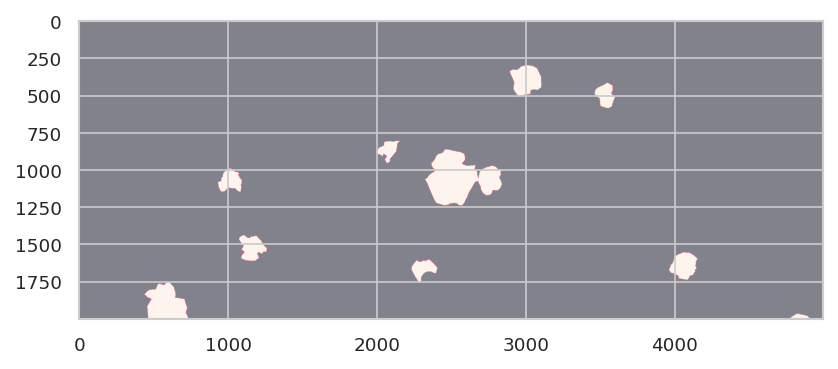

In [104]:
plt.figure(dpi=150)
plt.imshow(
    TEST_GT[6000:8000, 5000:10_000]>0, alpha=0.5
)
plt.show()

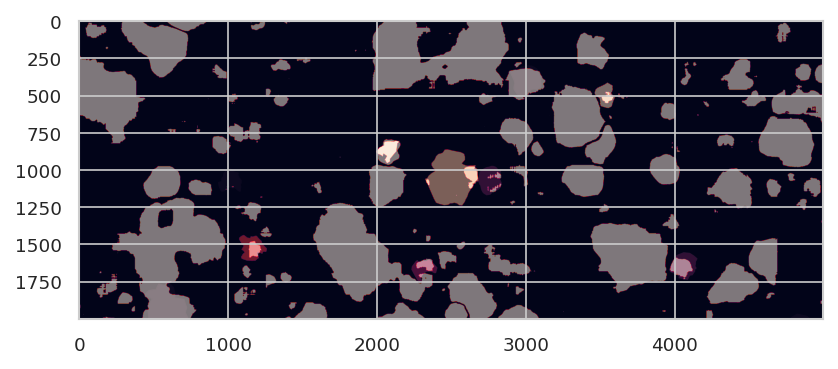

In [106]:

plt.figure(dpi=150)
plt.imshow(
    prob_pred[6000:8000, 5000:10_000] > 0.7
)
plt.imshow(
    TEST_GT[6000:8000, 5000:10_000], alpha=0.5
)

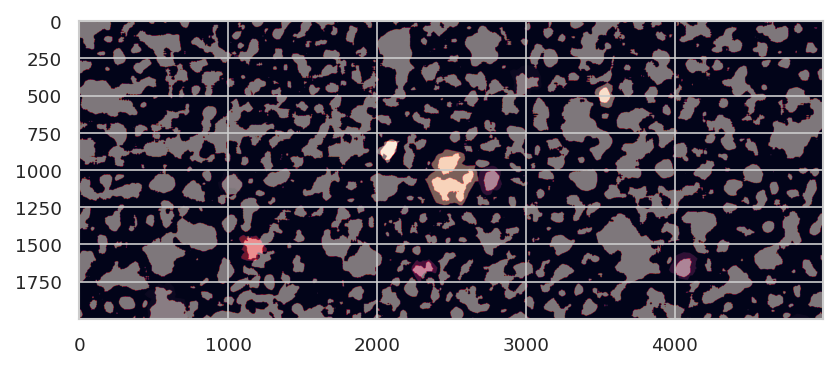

In [124]:

plt.figure(dpi=150)
plt.imshow(
    depth_pred[6000:8000, 5000:10_000] > 0.3
)
plt.imshow(
    TEST_GT[6000:8000, 5000:10_000], alpha=0.5
)

<Axes: ylabel='Count'>

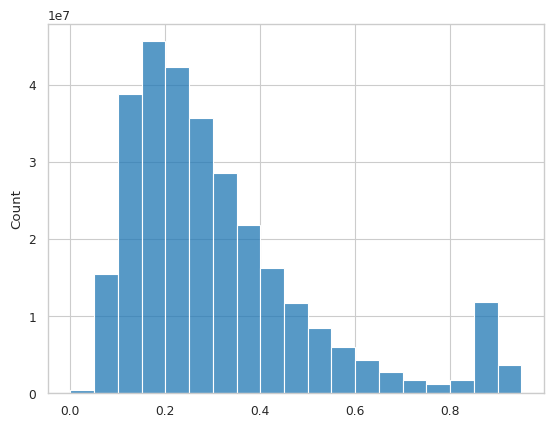

In [116]:
sns.histplot(
    depth_pred.ravel(), 
    bins=np.arange(0,1, 0.05)
)

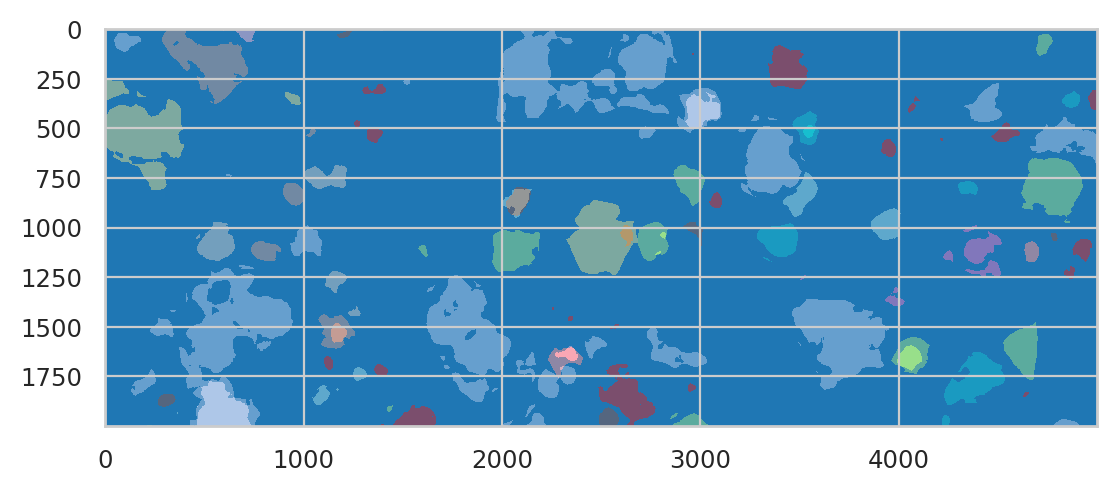

In [136]:
plt.figure(dpi=200)

plt.imshow(
    np.where(((new_pred_map>0.7) & (depth_pred>0.2)), class_pred, 0)[6000:8000, 5000:10_000],
    cmap="tab20",
    interpolation="nearest"
)

plt.imshow(
    TEST_GT[6000:8000, 5000:10_000], alpha=0.5,
    cmap="tab20",
    interpolation="nearest"
)
# plt.grid(False)
plt.show()

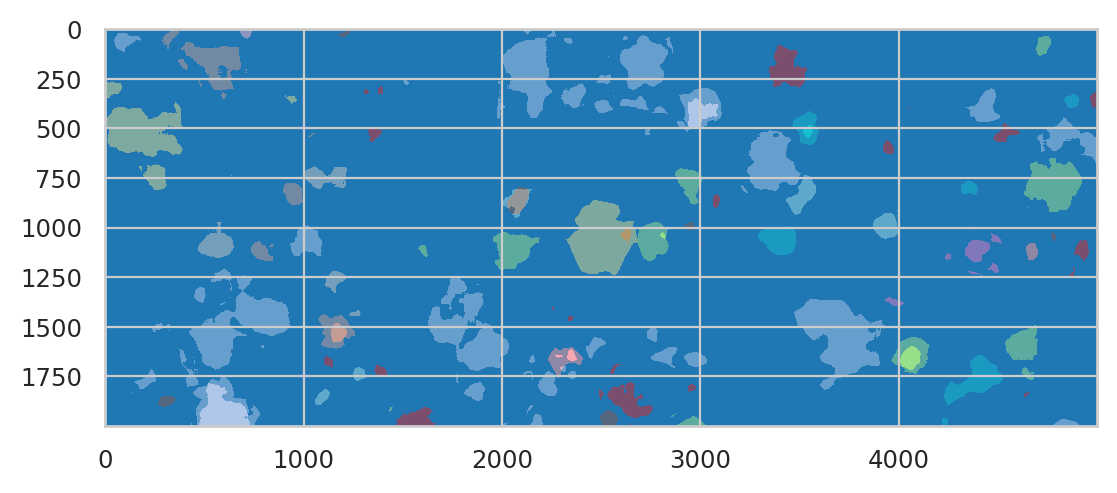

In [147]:
plt.figure(dpi=200)

plt.imshow(
    np.where(((new_pred_map>0.7) & (depth_pred>0.3)), class_pred, 0)[6000:8000, 5000:10_000],
    cmap="tab20",
    interpolation="nearest"
)

plt.imshow(
    TEST_GT[6000:8000, 5000:10_000], alpha=0.5,
    cmap="tab20",
    interpolation="nearest"
)
# plt.grid(False)
plt.show()

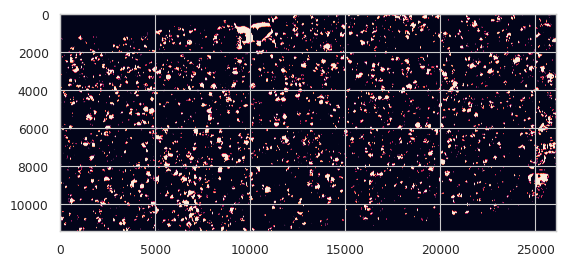

In [143]:
plt.imshow((new_pred_map>0.9) & (depth_pred>0.3))

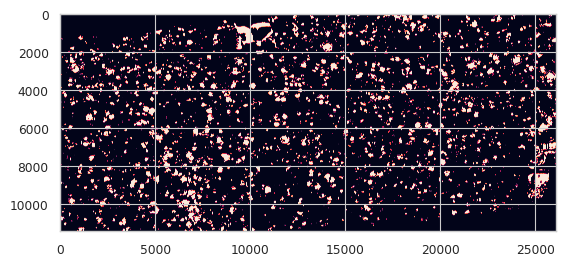

In [145]:
plt.imshow((new_pred_map>0.7) & (depth_pred>0.2))

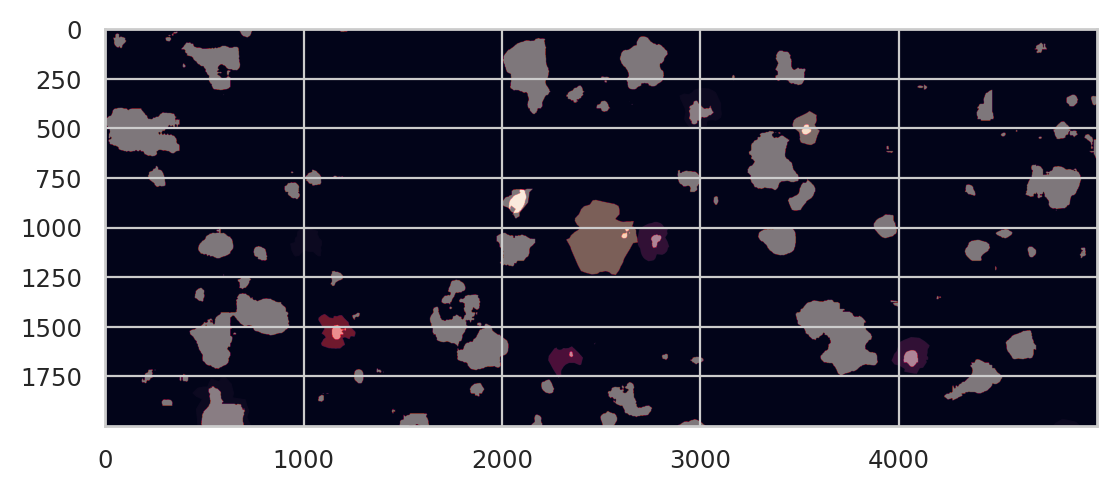

In [107]:
plt.figure(dpi=200)

plt.imshow(
    np.where(((prob_pred + depth_pred)>1.3)[6000:8000, 5000:10_000], 
             1, 0)
)
plt.imshow(
    TEST_GT[6000:8000, 5000:10_000], alpha=0.5
)
# plt.grid(False)
plt.show()

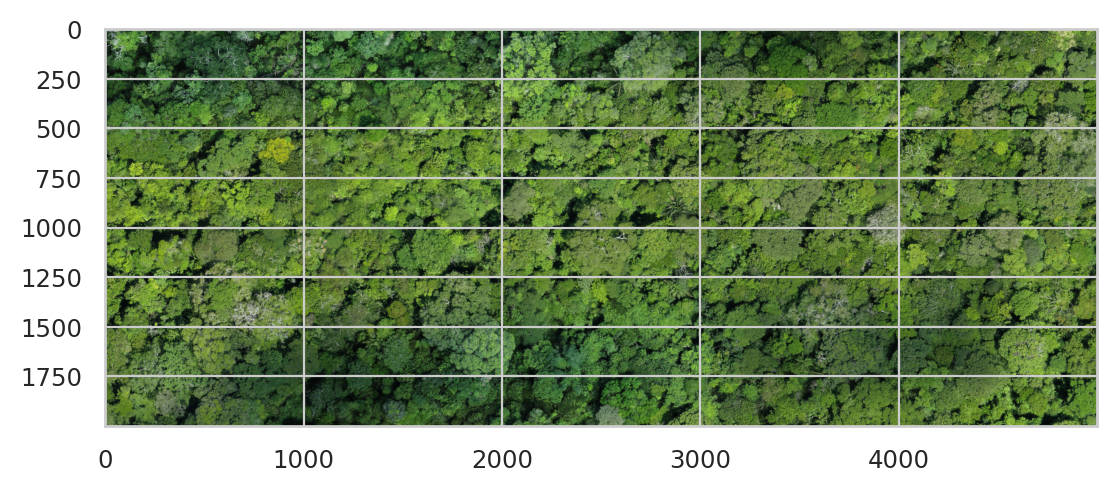

In [58]:
plt.figure(dpi=200)

plt.imshow(
    ORTHOIMAGE[6_000:8_000, 5_000:10_000]
)
# plt.grid(False)
plt.show()

In [10]:
filter_components_by_geometric_property(
    new_pred_map, 
    low_limit = np.float32(args.lower_limit_area), 
    high_limit = np.float32(args.upper_limit_area), # high limit area
    property = "area"
)

In [11]:
filter_components_by_mask(new_pred_map)

Filtering components out of the area of the experiment


100%|██████████| 63/63 [00:19<00:00,  3.21it/s]


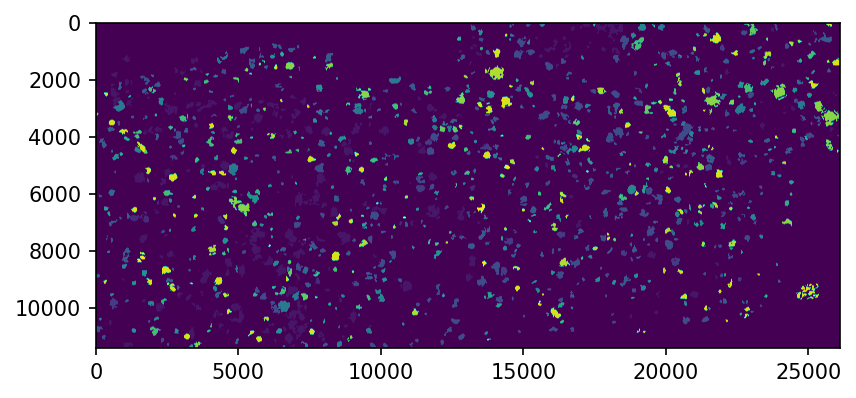

In [12]:
plt.figure(dpi=150)
plt.imshow(new_pred_map)
plt.show()

In [13]:
COMP_GT_TRAIN = label(TRAIN_GT)

In [14]:
comp_new_pred = label(new_pred_map)

In [15]:
new_pred_stats = get_components_stats(comp_new_pred, new_pred_map)

In [16]:
train_stats = get_components_stats(COMP_GT_TRAIN, TRAIN_GT)

In [91]:
pixel_size_x*pixel_size_y

0.0015999999999994393

In [110]:
train_stats.sort_values("area", ascending=False, inplace=True)

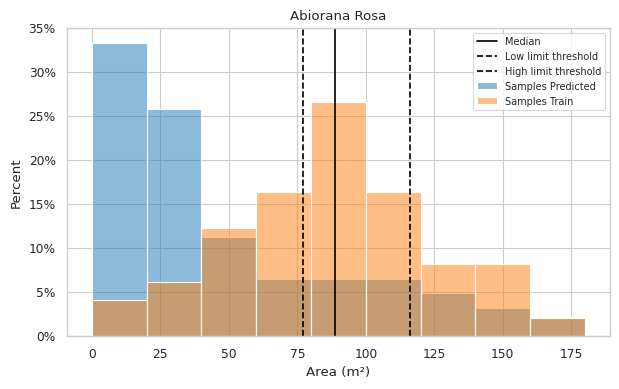

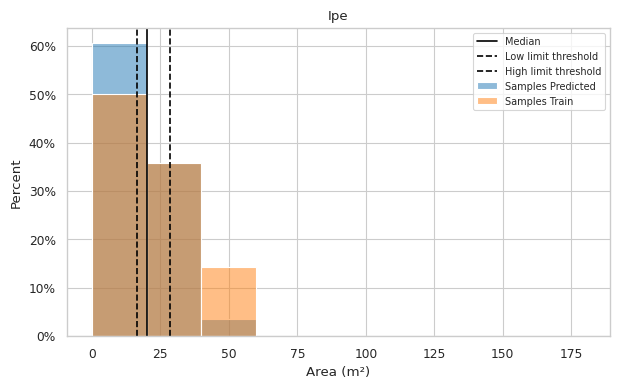

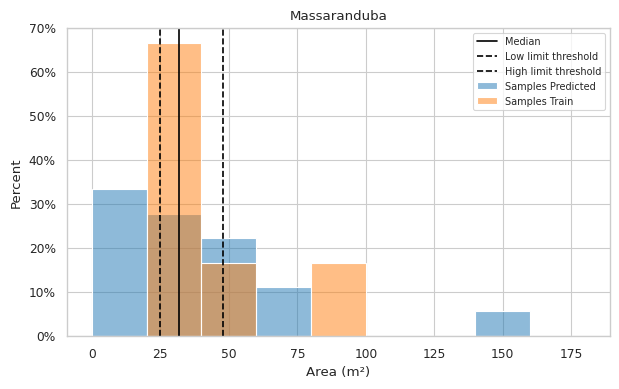

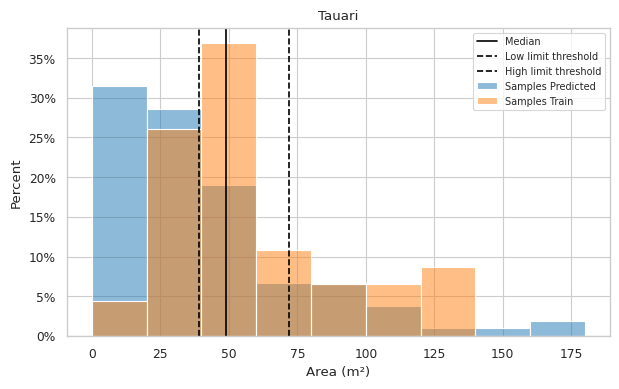

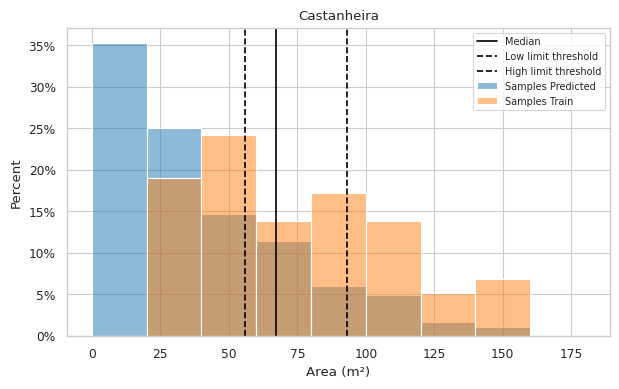

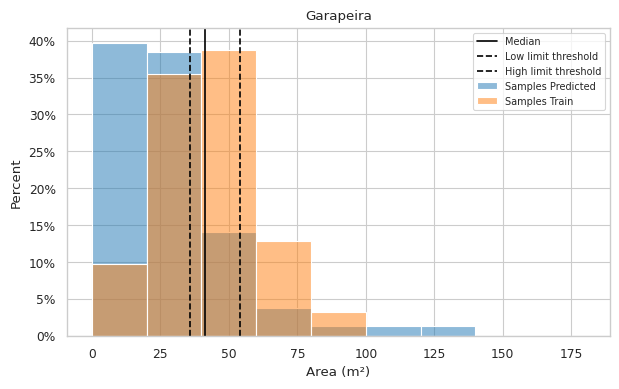

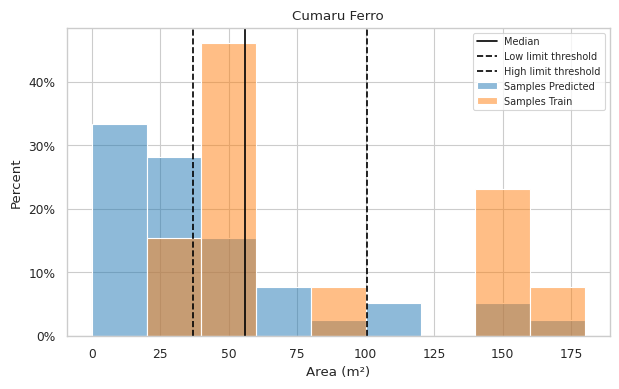

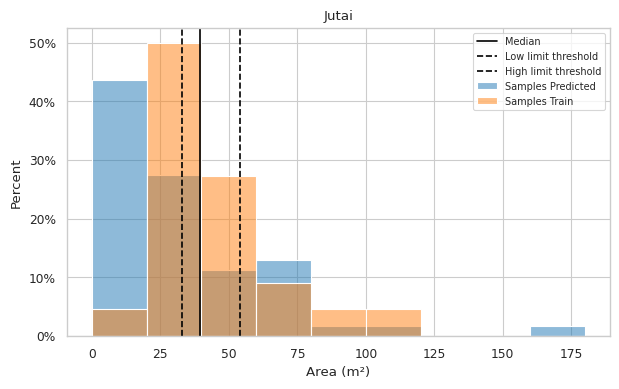

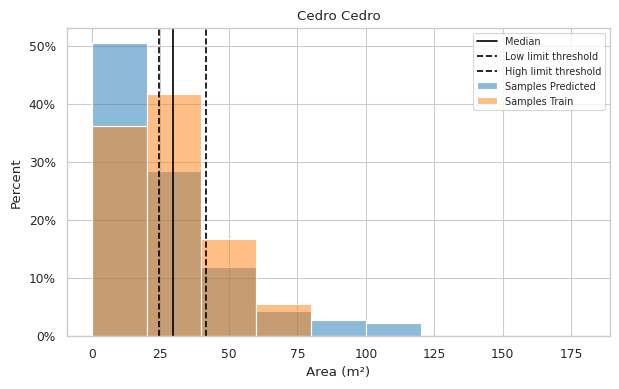

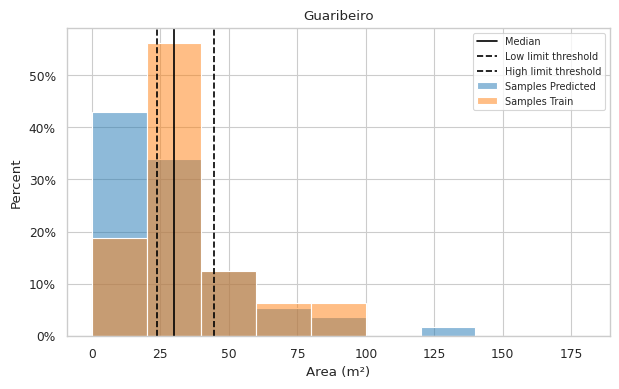

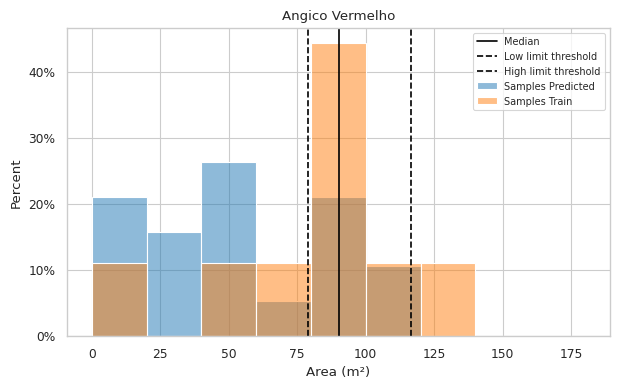

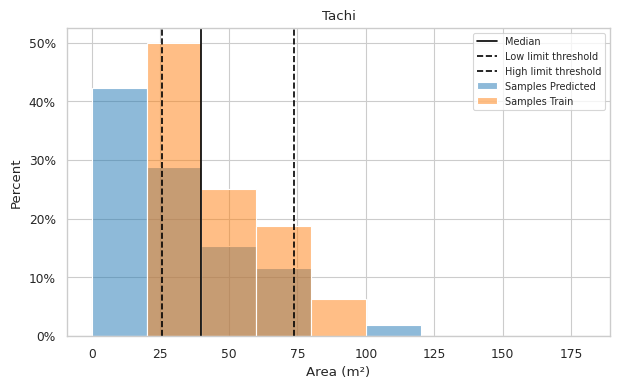

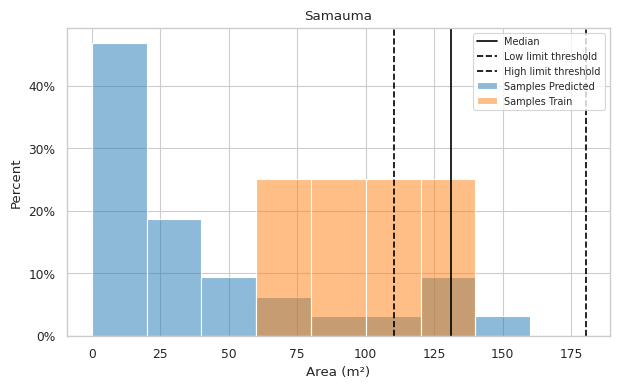

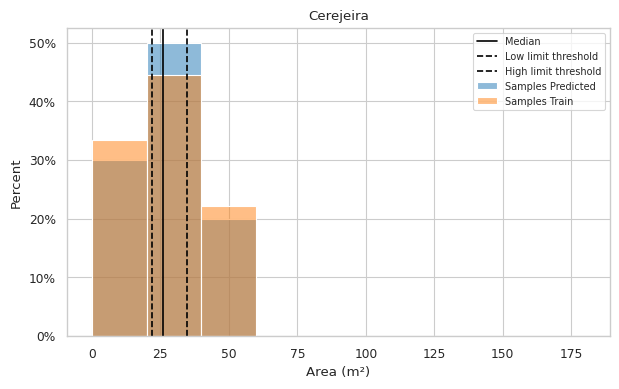

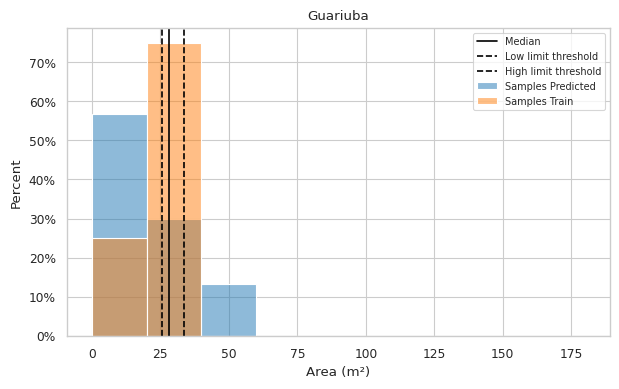

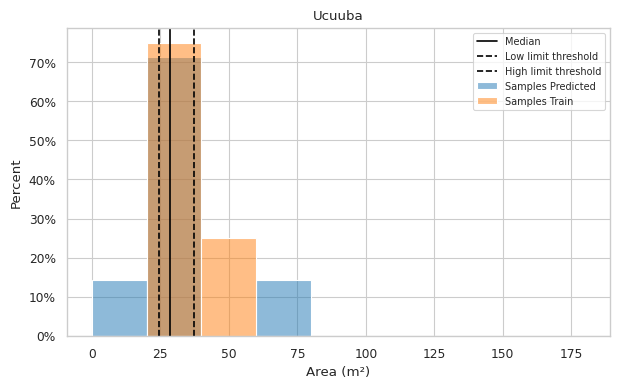

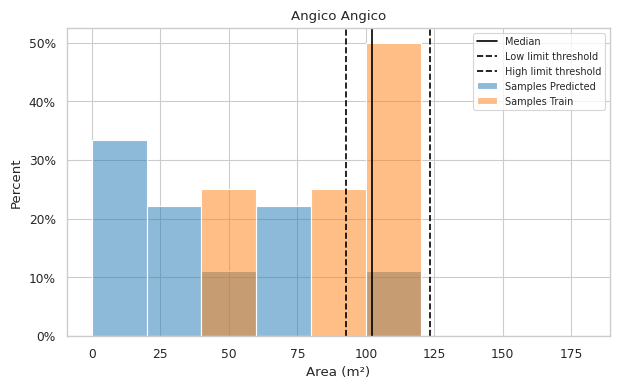

In [84]:

for tree_type_num in new_pred_stats["tree_type"].unique():
    
    train_stats_area = train_stats[train_stats["tree_type"] == tree_type_num]["area"]* pixel_size_x * pixel_size_y
    new_pred_stats_area = new_pred_stats[new_pred_stats["tree_type"] == tree_type_num]["area"]* pixel_size_x * pixel_size_y
    
    
    median_train = train_stats_area.median() 
    
    low_thr = median_train + args.lower_limit_area_rlted_to_tree_type*median_train
    high_thr = median_train + args.upper_limit_area_rlted_to_tree_type*median_train
    
    var = train_stats_area.std()
    low_thr = median_train + args.lower_limit_area_rlted_to_tree_type*var
    high_thr = median_train + args.upper_limit_area_rlted_to_tree_type*var
    
    fig, ax = plt.subplots(figsize=(7, 4))
    # plot histogram comparison
    sns.histplot(new_pred_stats_area,
                 bins=np.arange(0, 200, 20),
                #  color="red", 
                 alpha=0.5, 
                 label="Samples Predicted", 
                 stat="percent",
                 ax=ax)
    
    sns.histplot(train_stats_area, 
                 bins=np.arange(0, 200, 20),
                #  color="blue", 
                 alpha=0.5, 
                 label="Samples Train", 
                 stat="percent",
                 ax=ax)
    
    # draw vertical lines
    # median
    ax.axvline(median_train, color="black", linestyle="-", label="Median")
    ax.axvline(low_thr, color="black", linestyle="--", label="Low limit threshold")
    ax.axvline(high_thr, color="black", linestyle="--", label="High limit threshold")
    
    # set log scale
    # plt.xscale("log")
    ax.set_xlabel("Area (m²)")
    
    # convert y ticks to percentage
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.0f}%"))
    
    plt.title(f"{id_tree[tree_type_num]}")
    
    plt.legend(loc='upper right', fontsize=7)
    plt.savefig(
        f"figures/area_distribution_{id_tree[tree_type_num]}.png",
        dpi=120,
        bbox_inches="tight",
        
    )
    plt.show() 
    

# Descobrindo a posição do Dataset em coordenadas

In [133]:

from pyproj import Transformer

# Open the TIFF file
with rasterio.open(args.train_segmentation_path) as src:
    # Define the source CRS (UTM zone 19S) and target CRS (WGS 84)
    transformer = Transformer.from_crs("epsg:32719", "epsg:4326", always_xy=True)
    
    # Example: Transform the upper-left corner of the image
    ul_lon, ul_lat = transformer.transform(src.bounds.left, src.bounds.top)
    lr_lon, lr_lat = transformer.transform(src.bounds.right, src.bounds.bottom)
    
    print(f"The geographic coordinates of the upper-left corner are Longitude: {ul_lat},{ul_lon}")
    print(f"The geographic coordinates of the lower-right corner are Longitude: {lr_lat},{lr_lon}")
    # print all the corners
    
    top_left = transformer.transform(src.bounds.left, src.bounds.top)
    top_right = transformer.transform(src.bounds.right, src.bounds.top)
    bottom_left = transformer.transform(src.bounds.left, src.bounds.bottom)
    bottom_right = transformer.transform(src.bounds.right, src.bounds.bottom)
    
    # convert point (100,100) on image to coordinate
    x, y = 100, 100
    x, y = src.xy(x, y)
    print(transformer.transform(x, y))
    
    print(top_left[::-1])
    print(top_right[::-1])
    print(bottom_left[::-1])
    print(bottom_right[::-1])

The geographic coordinates of the upper-left corner are Longitude: -10.030588862913605,-67.69294583728929
The geographic coordinates of the lower-right corner are Longitude: -10.034686363295364,-67.68340335631646
(-67.69290901737492, -10.030625068058685)
(-10.030588862913605, -67.69294583728929)
(-10.03055120553111, -67.68342006071323)
(-10.034724036511856, -67.69292925366871)
(-10.034686363295364, -67.68340335631646)


In [138]:
train_stats

,area,convex_area,bbox_area,extent,solidity,eccentricity,orientation,centroid-0,centroid-1,bbox-0,bbox-1,bbox-2,bbox-3,tree_type
label,,,,,,,,,,,,,,
75,161692.0,176366.0,243033.0,0.665309,0.916798,0.133339,-0.943351,3304.183602,25745.535320,3048,25501,3537,25998,14
22,146053.0,163859.0,235042.0,0.621391,0.891333,0.609278,-1.489092,1754.398102,14041.764407,1550,13784,1996,14311,15
326,141238.0,153156.0,208377.0,0.677800,0.922184,0.575745,1.309613,9946.124039,6595.870722,9750,6332,10161,6839,7
37,133771.0,148752.0,198942.0,0.672412,0.899289,0.715453,-0.866542,2484.840862,23988.119473,2271,23740,2697,24207,14
48,122431.0,146958.0,204885.0,0.597560,0.833102,0.506048,-1.270515,2754.999845,21668.665077,2537,21450,2972,21921,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,4906.0,6122.0,10044.0,0.488451,0.801372,0.830957,0.641537,7539.761517,18720.995720,7480,18679,7588,18772,5
82,4256.0,4829.0,7176.0,0.593088,0.881342,0.719824,-0.502826,3345.848919,1767.238487,3306,1728,3398,1806,5
307,4221.0,4857.0,8025.0,0.525981,0.869055,0.894352,1.166107,9270.504146,23790.091211,9231,23737,9306,23844,5


In [139]:
biggest_tree_pos = tuple(train_stats.loc[22,["centroid-0", "centroid-1"]].values)
biggest_tree_pos = src.xy(*biggest_tree_pos)

biggest_tree_pos = transformer.transform(*biggest_tree_pos)
biggest_tree_pos[::-1]

(-10.03120336317126, -67.68781902565671)

In [135]:
train_stats["area"]* pixel_size_x * pixel_size_y

label
75     258.7072
22     233.6848
326    225.9808
37     214.0336
48     195.8896
         ...   
247      7.8496
82       6.8096
307      6.7536
184      4.1120
262      4.0448
Name: area, Length: 355, dtype: float64